# Learning from data - CW1 - Clustering

## Model answer for CW1

*<font color='red'>Please note that this is just one of the many possible ways to correctly implement (and also describe!) what I asked in the coursework.</font>*


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


To ensure reproducibility, seed the random number generator. The cell below can be deleted to examine different results:

In [6]:
np.random.seed(1790)

## K-means with Euclidean distance

Data can be standardized to make the features more receptive to modelling techniques.

The equation for doing so takes the form:

\begin{align*}
z = \frac{x-\mu}{\sigma}
\end{align*}

Define a function that will standardize a dataset in place:

In [7]:
def standardize(data):
    data -= np.mean(data, axis=0)
    data /=  np.std(data, axis=0)

The k-means algorithm takes an iterative approach and often performs very well in practice. For it to work, it requires a distance metric in order to group the dataset into clusters. The standard metric is (the squared) Euclidean distance, which is given by the equation:

\begin{align*}
d(x,y) = \lVert x-y \lVert^2_2
\end{align*}

Define a function that takes a data point and a set of centroids and calculates the distances to each. This will allow easier batch searching:

In [8]:
def euclidean_distance(x, mu):
    return np.linalg.norm(x - mu, axis=1) ** 2

Define a k-means algorithm with Euclidean distance and standard centroid cluster representative:

In [9]:
def euclidean_kmeans(X, k, max_itr):
    P = None
    mu = X[np.random.randint(X.shape[0], size=k)]
    
    for t in range(max_itr):
        C = np.zeros(X.shape[0])

        for i in range(X.shape[0]):
            C[i] = np.argmin(euclidean_distance(X[i], mu))

        for i in range(k):
            if np.count_nonzero(C == i) == 0:
                C[np.random.randint(0, C.shape[0])] = i
                
        for i in range(k):
            mu[i] = np.mean(X[C==i], axis=0)
        
        if np.array_equal(P, C):
            return C
        
        P = C
    
    return P

There are two deviations from the standard algorithm that are implemented here:

- I've initialized the centroids with $k$ random points in the dataset. This ensures that each centroid will contain at least one point in the first itteration. Note that when you pick a random point in the sample space it could sometimes cause clusters of zero size.

- As a secondary precaution, I've added a check for empty clusters. Reseeding the algorithm with a random point makes the most intuitive sense, as it forces the algorithm to settle in a local optima that contains the asked cluster count.

To test the algorithm, it would be helpful to generate a dataset of circles. Euclidian distance can accurately model data that has a center and radius.

A random point in a circle can be generated by calculating a polar coordinate. To get a linear distribution, the radius should be square-rooted to ensure a clustering in the center does not form:

\begin{align*}
r = \sqrt{x\in[0, 1]}
\end{align*}

\begin{align*}
\theta = x \in [0, 1] \times 2 \times \pi
\end{align*}

Define a generator for random spherical datasets:

In [10]:
def generate_circle(center, radius, n):
    r = np.sqrt(np.random.rand((n)))

    theta = np.random.rand((n)) * (2 * np.pi)

    return np.array([r * np.cos(theta), r * np.sin(theta)]).T + center

As an example of the algorithm working, generate a dataset of two circles:

In [11]:
X = np.concatenate((generate_circle(np.array([0, 0]), 1, 250),
                    generate_circle(np.array([2, 2]), 1, 250),
                    generate_circle(np.array([-1, 2.5]), 1, 250)), axis=0)

Standardize and shuffle the data to ensure a fair trail:

In [12]:
standardize(X)
np.random.shuffle(X)

Run the algorithm and plot the results:

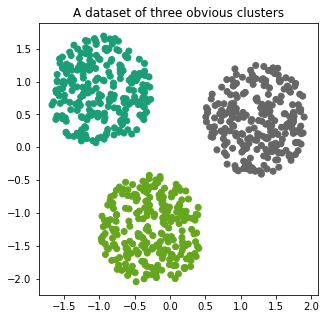

In [13]:
P = euclidean_kmeans(X, 3, 100)

figsize(5, 5)
plt.scatter(X[:,0], X[:,1], c=P, cmap="Dark2")
plt.title("A dataset of three obvious clusters")
plt.axis('tight')
plt.show()

As another proof of utility, the function can handle an arbitary number of dimensions. Here I create two blobs of data with three features and cluster them using k-means:

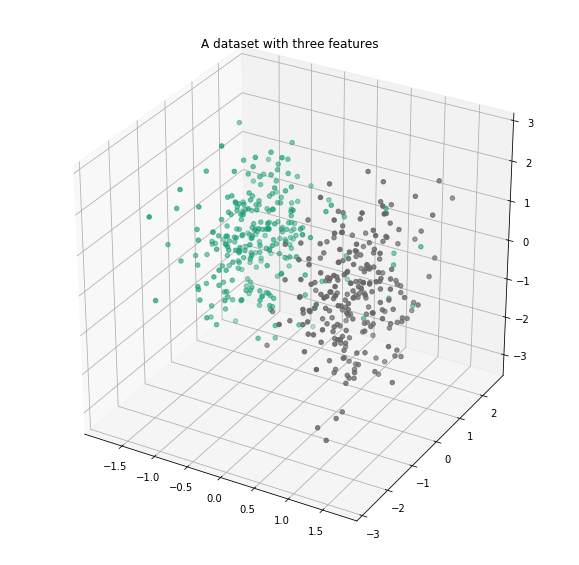

In [14]:
from sklearn.datasets.samples_generator import make_blobs
from mpl_toolkits.mplot3d import Axes3D

X = make_blobs(n_samples=500, centers=2, n_features=3, random_state=0)[0]

standardize(X)
np.random.shuffle(X)

P = euclidean_kmeans(X, 2, 100)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,1], X[:,2], X[:,0], c=P, cmap="Dark2")
plt.title("A dataset with three features")
plt.axis('tight')
plt.show()

## K-means Mahalanobis distance

This works well as this implementation can only accurately models spherical clusters that have a center and radius. To handle ellipsoids or clusters with unequal variance on different directions, we must use the Mahalanobis distance.

Mahalanobis distance uses the covariance matrix of the data inside each cluster. The covariance matrix is as follows:

\begin{align*}
S = \frac{1}{N-1}X^TX
\end{align*}

Where $X\in \mathbb{R}^{N \times d}$ is the data matrix of cluster $C$.

Using the covariance matrix, you can calculate Mahalanobis distance using the below equation:

\begin{align*}
d_M(x,C) = \sqrt{(x-\mu)^TS^{-1}(x-\mu)}
\end{align*}

Define a function that will calculate the distances to each centroid from a given point:

In [15]:
def mahalanobis_distance(x, mu, cov):
    distances = []
    for i in range(len(mu)):
        d = (x - mu[i]).T @ np.linalg.inv(cov[i]) @ (x - mu[i])
        d = np.sqrt(d)
        distances.append(d)
    
    return np.array(distances)

To demonstrate how the distance acts in different directions, below is a grid around a dataset:

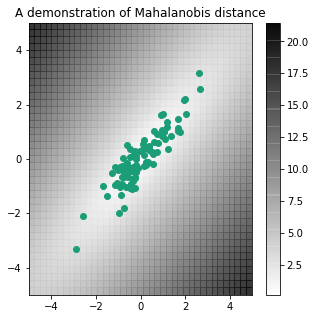

In [16]:
X = np.random.multivariate_normal([0, 0], [[5, 4.5], [4.5, 5]], 100)

standardize(X)

mean =  np.mean(X, axis=0)
cov = (1 / (X.shape[0] - 1))
cov *= X.T @ X

N = 40

Xgrid = linspace(-5, 5, N)
Ygrid = linspace(-5, 5, N)
distance = zeros((N,N,2))

for ny, y in enumerate(Ygrid):
    for nx, x in enumerate(Xgrid):
        distance[ny, nx, :] = mahalanobis_distance(np.array([x, y]), [mean], [cov])[0]

figsize(5, 5)

pcolor(Xgrid, Ygrid, distance[:,:,1], cmap="binary", alpha=0.8)
colorbar()
plt.scatter(X[:,0], X[:,1], c='#1b9e77')
plt.axis((-5, 5, -5, 5))
plt.title("A demonstration of Mahalanobis distance")
plt.show()

Notice how the distance is not circular, but models the covariance and in turn the correlation of the data. This means that this distance metric is better suited to ellipsoidal datasets.

Define a k-means algorithm that uses the Mahalonobis distance:

In [17]:
def mahalanobis_kmeans(X, k, max_itr):
    # initial partition given by standard kmeans
    P = euclidean_kmeans(X, k, 1)

    mu = X[np.random.randint(X.shape[0], size=k)]
    cov = [[] for x in range(k)]

    for t in range(max_itr):
        for i in range(k):
            if np.count_nonzero(P == i) == 0:
                P[np.random.randint(0, P.shape[0])] = i

        for i in range(k):
            points = X[P==i]

            mu[i] = np.mean(points, axis=0)
            cov[i] = np.cov(points.T)

        C = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            C[i] = np.argmin(mahalanobis_distance(X[i], mu, cov))

        if np.array_equal(P, C):
            return C

        P = C
    
    return P

For this implementation the covariance is also needed to calculate the distance. Because of this, an initial division of the data into sets is required. After research online, it seems the most logical approach is to run one iteration of k-means with Euclidean distance. By doing this the sets are randomly divided and the extra covariance matrix can be calculated.

Define a generator for random ellipsoid datasets, to confirm the better results that are to be expected from Mahalanobis:

In [18]:
def generate_ellipsoid(center, scale, n):
    theta = np.random.rand((n)) * (2 * np.pi)
    r = np.random.normal(0, 1, n)
    return np.array([(scale[0] * r * np.cos(theta)), (scale[1] * r * np.sin(theta))]).T + center

Compare Euclidean and Mahalonobis distances on a dataset of two ellipsoids:

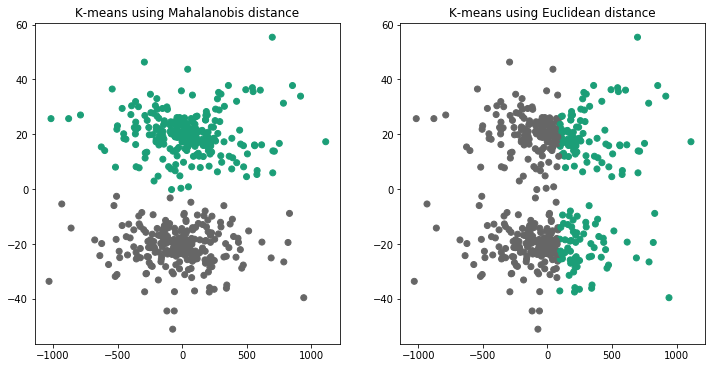

In [26]:
X = np.concatenate((generate_ellipsoid(np.array([0, 20]), [400, 10], 250),
                    generate_ellipsoid(np.array([0, -20]), [400, 10], 250)), axis=0)

np.random.shuffle(X)

figure(figsize=(12,13))

P = mahalanobis_kmeans(X, 2, 20)

plt.subplot(221)
plt.title("K-means using Mahalanobis distance")
plt.scatter(X[:,0], X[:,1], c=P, cmap="Dark2")

P = euclidean_kmeans(X, 2, 20)

plt.subplot(222)
plt.title("K-means using Euclidean distance")
plt.scatter(X[:,0], X[:,1], c=P, cmap="Dark2")

plt.show()

The Mahalanobis distance metric is much better on this dataset, nearly always classifying the two clusters accurately. The Euclidean distance on the other hand fails to seperate the two clusters, instead causing a vertical divide. 

The above graphs demonstrates how the Euclidean distance only works for spherical data, and as a result can't classify two ellipsoids that would be overlapping if the maximal radial distance was in both dimensions.

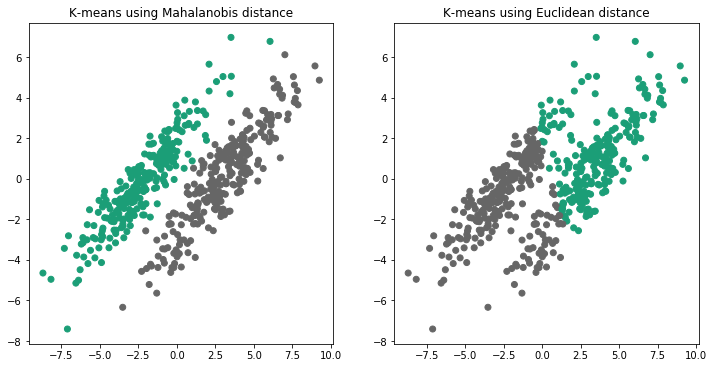

In [32]:
X = np.concatenate((np.random.multivariate_normal([-2, 0], [[5, 4.5], [4.5, 5]], 250),
                    np.random.multivariate_normal([3, 0], [[5, 4.5], [4.5, 5]], 250)), axis=0)

np.random.shuffle(X)

figure(figsize=(12,13))


P = mahalanobis_kmeans(X, 2, 20)

plt.subplot(221)
plt.title("K-means using Mahalanobis distance")
plt.scatter(X[:,0], X[:,1], c=P, cmap="Dark2")

P = euclidean_kmeans(X, 2, 20)

plt.subplot(222)
plt.title("K-means using Euclidean distance")
plt.scatter(X[:,0], X[:,1], c=P, cmap="Dark2")

plt.show()

This is another interesting dataset that I found when testing the two distances. Even those these aren't ellipsoidal, they can be approximated as such. The accuracy is as a result slightly lower, but in general performs well. On the other hand, Euclidean fails every time that I have tested it.

It is interesting to note that sometimes Mahalanobis doesn't complete if it gets a particularly unfortunate initial seeding. It doesn't complete when a cluster has a size of one, this is because the covariance matrix becomes malformed and the inverse cannot be calculated. One solution to this would be to use the pseudo-inverse.

## Davies Bouldin Index

Without a gold-standard, the clustering quality cannot be compared directly. In general though, a good cluster is defined as being compact and seperated.

One way of numerically defining these favourable attributes is the Davies Bouldin index:


\begin{align*}
DB(C) = \frac{1}{k} \sum_{i=1}^{k}\max_{j \leq k, j \neq i} D_{ij}
\end{align*}

Where:

\begin{align*}
k = |C|, D_{ij}=\frac{(\bar{d_i} + \bar{d_j})}{d_{ij}}
\end{align*}

Define a function to calculate the index:


In [33]:
def average_distance(cluster):
    centroid = np.mean(cluster, axis=0)
    distances = np.linalg.norm(cluster - centroid, axis=1)

    return np.mean(distances)

def cluster_distance(a, b):
    return np.linalg.norm(np.mean(a, axis=0) - np.mean(b, axis=0))
    
def davies_bouldin(X, P, k):
    total = 0
    for i in range(k):
        max_ratio = 0
        for j in range(k):
            if i == j:
                continue
            
            ratio = average_distance(X[P == i]) + average_distance(X[P == j])
            ratio /= cluster_distance(X[P == i], X[P == j])
            
            if ratio > max_ratio:
                max_ratio = ratio
        
        total += max_ratio
    
    return (1/k)*total

Load test data from local file and plot:

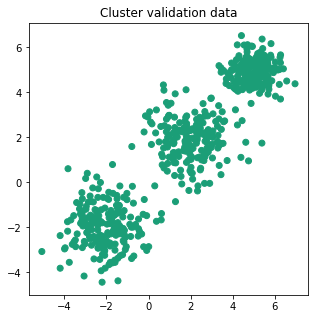

In [34]:
X = np.genfromtxt("./cluster_validation_data", delimiter=",")

plt.title("Cluster validation data")
plt.scatter(X[:,0],X[:,1], c=np.zeros(X.shape[0]), cmap="Dark2")
plt.show()

From visual inspection, it is clear that there are three clusters. These clusters appear circular, so will be well recieved by the Euclidean distance metric.

With k-means the value $k$ must be provided. In cases where this is not possible as the data is unknown, the Davies Bouldin index can be used.

Run k-means for a set of $k$ values and calculate the Davies Bouldin index:

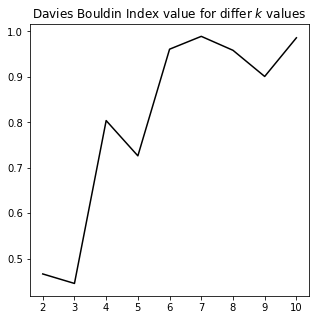

In [35]:
K = range(2, 11)
values = []

for k in K:
    P = euclidean_kmeans(X, k, 100)
    values.append(davies_bouldin(X, P, k))

plt.title("Davies Bouldin Index value for differ $k$ values")
plt.plot(K, values, "k")
plt.show()

As we had hoped, the value at $k=3$ is the lowest. This means that at this value of $k$ the clusters are most efficiently compacted and seperated.

As a side note; this still depends on the random seeding of the k-means algorithm. If it does not return $k=3$ as the optimal value then re-run it as it has become stuck in a local optima. In production, we would run this algorithm and pick the best clustering.

Print the clusters at the optimal $k$ value:

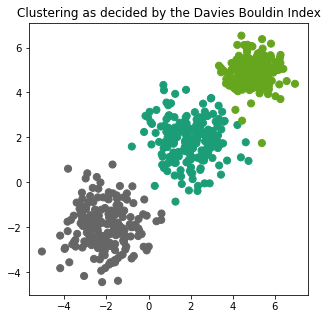

In [36]:
k = np.argmin(values) + 2

P = euclidean_kmeans(X, k, 100)

plt.title("Clustering as decided by the Davies Bouldin Index")

plt.scatter(X[:,0],X[:,1], c=P, s=50, cmap='Dark2')

plt.show()